Demo notebook for ptycho

Arthur McCray  
November 7, 2025

In [1]:
%load_ext autoreload 
%autoreload 2

In [2]:
from pathlib import Path
import numpy as np

import quantem as em
from quantem.core import config
from quantem.core.datastructures import Dataset4dstem
from quantem.diffractive_imaging import PtychographyDatasetRaster, PtychoLite, PtychoLiteDIP
from quantem.core.visualization import show_2d

# set the default/primary GPU device
config.set_device(2)
print(config.get("device"))

cuda:2


In [3]:
_f = Path("../data/ducky_251105_20mrad_500A-df_4A-step_5e+04-dose_clean.zip")
dset: Dataset4dstem = em.io.load(_f)
print(dset)

PROBE_ENERGY = 80e3 # eV
PROBE_SEMIANGLE = 20 # mrad
PROBE_DEFOCUS = 500 # A 

quantem Dataset named 'ducky_251105_clean'
  shape: (37, 37, 200, 200)
  dtype: float32
  device: cpu
  origin: [0. 0. 0. 0.]
  sampling: [4.    4.    0.025 0.025]
  units: ['A', 'A', 'A^-1', 'A^-1']
  signal units: 'arb. units'


Calculated best fit rotation = 0 degrees.


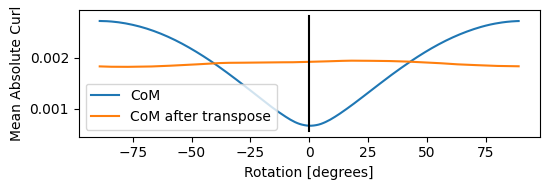

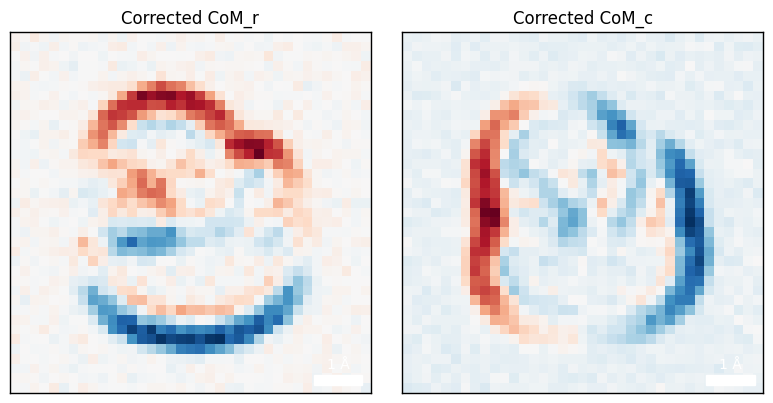

Normalizing intensities:   0%|          | 0/1369 [00:00<?, ?probe position/s]

In [4]:
pdset = PtychographyDatasetRaster.from_dataset4dstem(dset)

pdset.preprocess(
    com_fit_function="constant",
    plot_rotation=True,
    plot_com=True,
)

In [5]:
ptycho_pix = PtychoLite.from_dataset(
    dset=pdset,
    num_slices=1,
    num_probes=1,
    obj_type="pure_phase",
    energy=PROBE_ENERGY,
    defocus=PROBE_DEFOCUS,
    semiangle_cutoff=PROBE_SEMIANGLE,
    obj_padding_px=(32,32),
)

  0%|          | 0/100 [00:00<?, ?it/s]

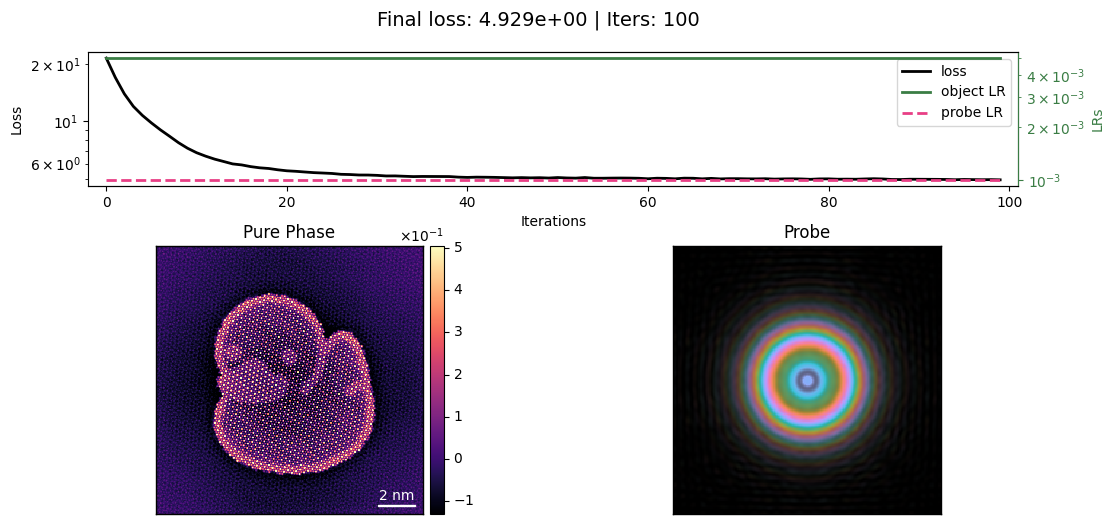

In [6]:
ptycho_pix.reconstruct(
    num_iters=100,
    reset=True,
    device="gpu", # this will run on the GPU already set by config.set_device()
    # equivalent to device=config.get("device")
    # device=3 will run on GPU 3, even if its not the default device
    batch_size=128,
).visualize()

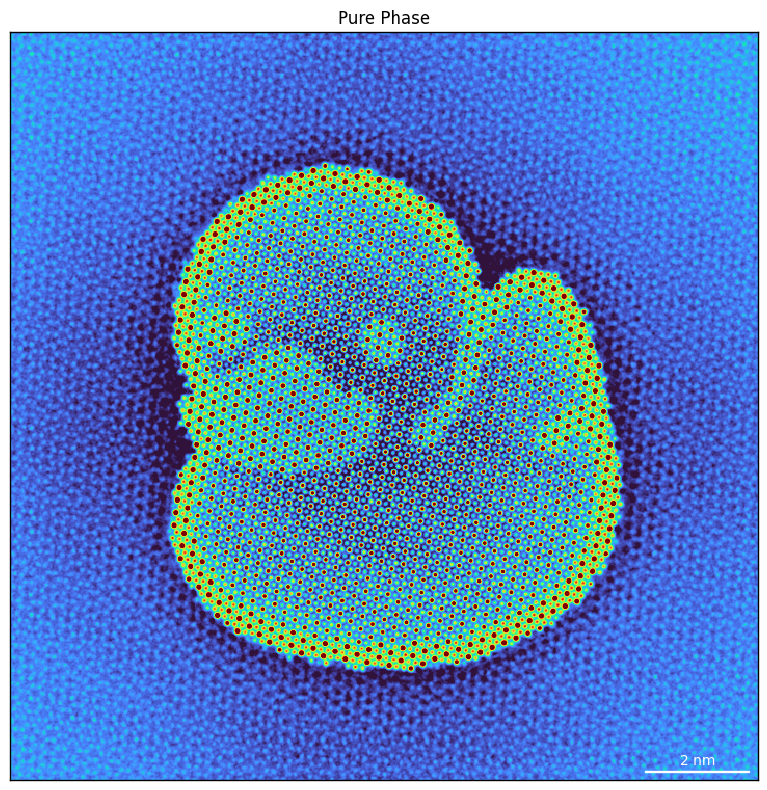

In [7]:
ptycho_pix.show_obj(axsize=(8,8), cmap='turbo')

  0%|          | 0/10 [00:00<?, ?it/s]

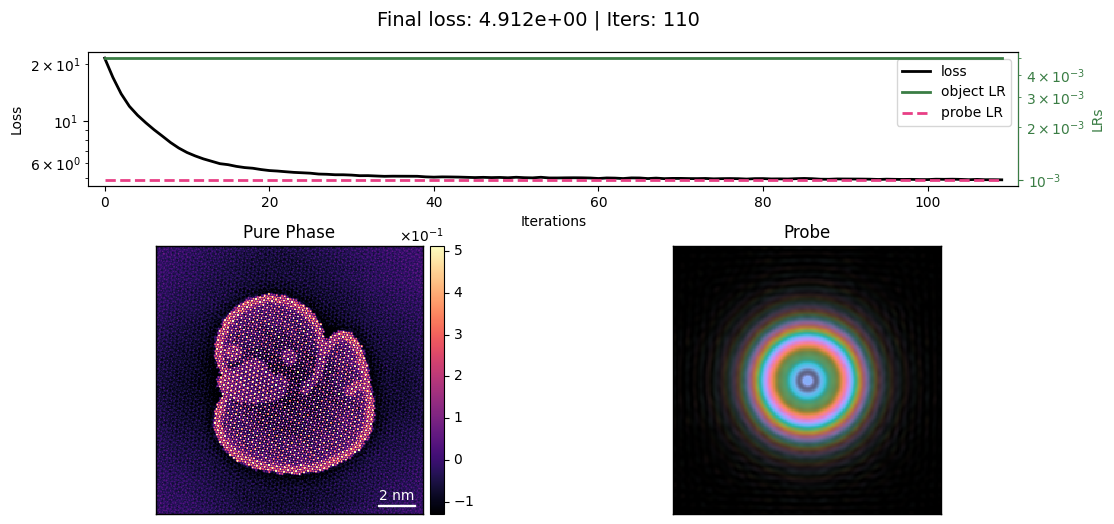

In [8]:
# default of reset=False, so will continue from previous reconstruction
ptycho_pix.reconstruct(num_iters=10).visualize()

## DIP

  0%|          | 0/10 [00:00<?, ?it/s]

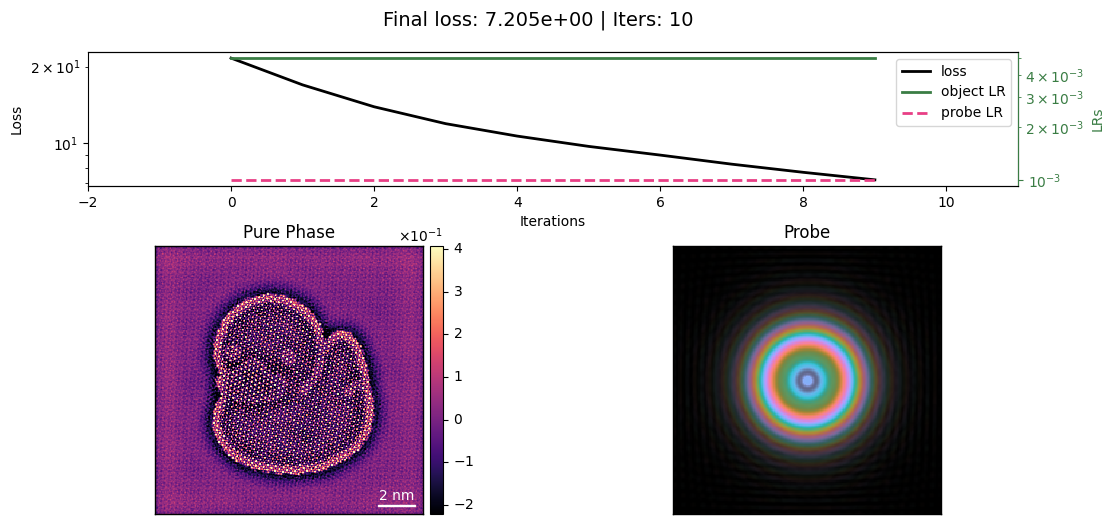

In [9]:
# create a new pixelated ptychography so we can run it for just a few iterations (to make the DGP reconstruction more difficult)
ptycho_pix2 = PtychoLite.from_ptychography(
    ptycho=ptycho_pix,
)
ptycho_pix2.reconstruct(num_iters=10).visualize()


  0%|          | 0/50 [00:00<?, ?it/s]

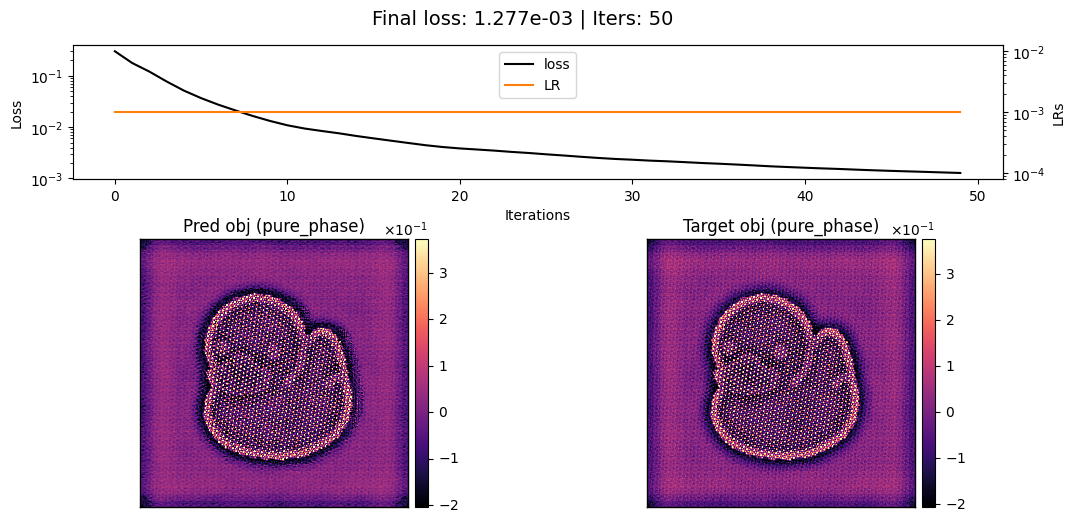

  0%|          | 0/50 [00:00<?, ?it/s]

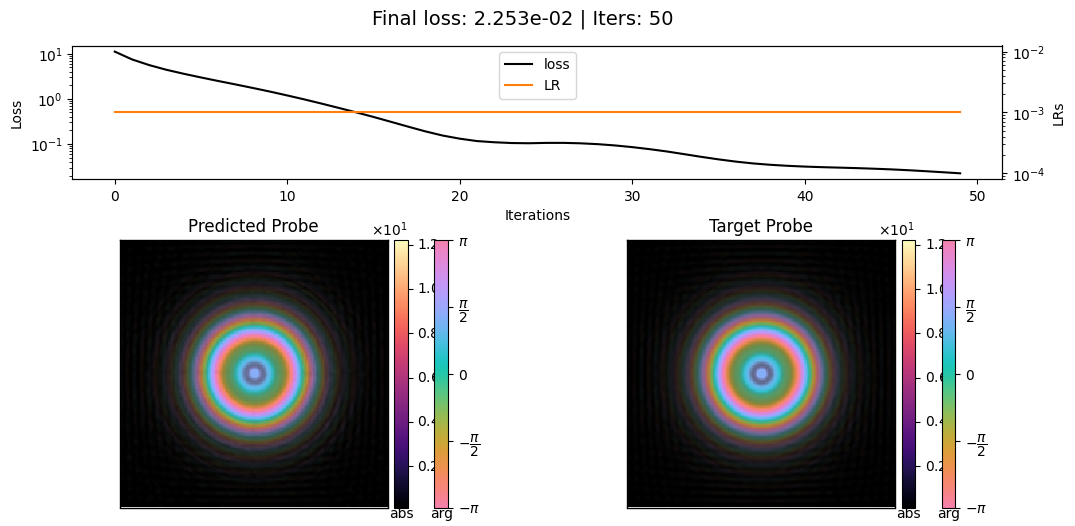

In [10]:
# pretraining and initialization from the pixelated ptychography
ptycho_dip = PtychoLiteDIP.from_ptycholite(
    ptycholite=ptycho_pix2,
    pretrain_iters=50,
    device='gpu', 
)

  0%|          | 0/25 [00:00<?, ?it/s]

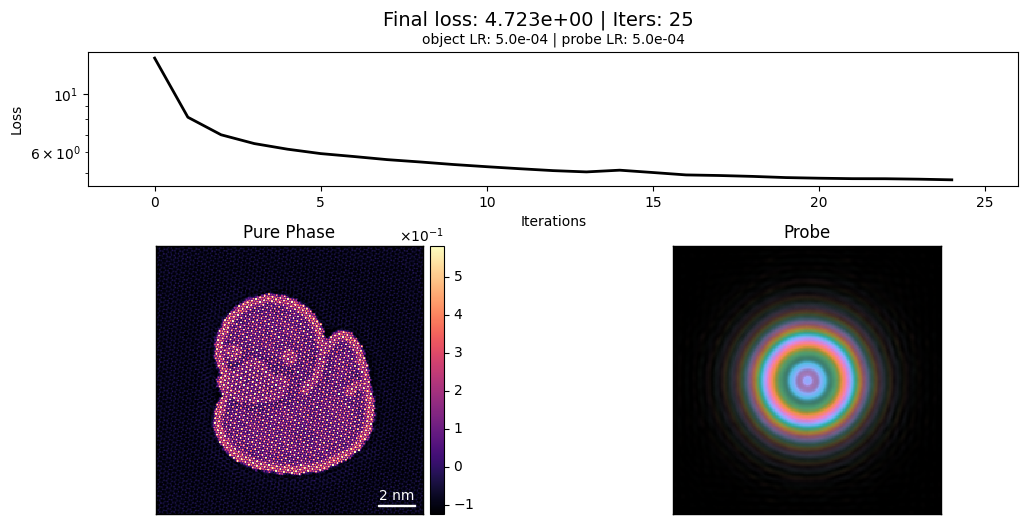

In [20]:
ptycho_dip.reconstruct(
    num_iters=25, 
    reset=True, 
    scheduler_type="plateau", # other scheduler types are `exp`, `cyclic`, `none` (default)
    batch_size=128,
).visualize()

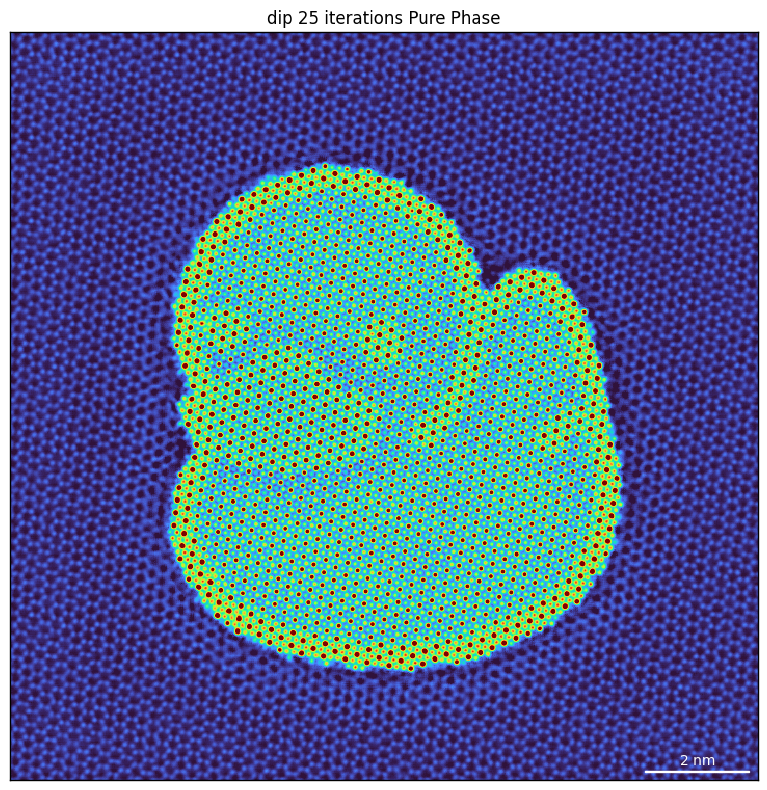

In [21]:
ptycho_dip.show_obj(axsize=(8,8), cmap='turbo', title=f'dip {ptycho_dip.num_iters} iterations')

  0%|          | 0/25 [00:00<?, ?it/s]

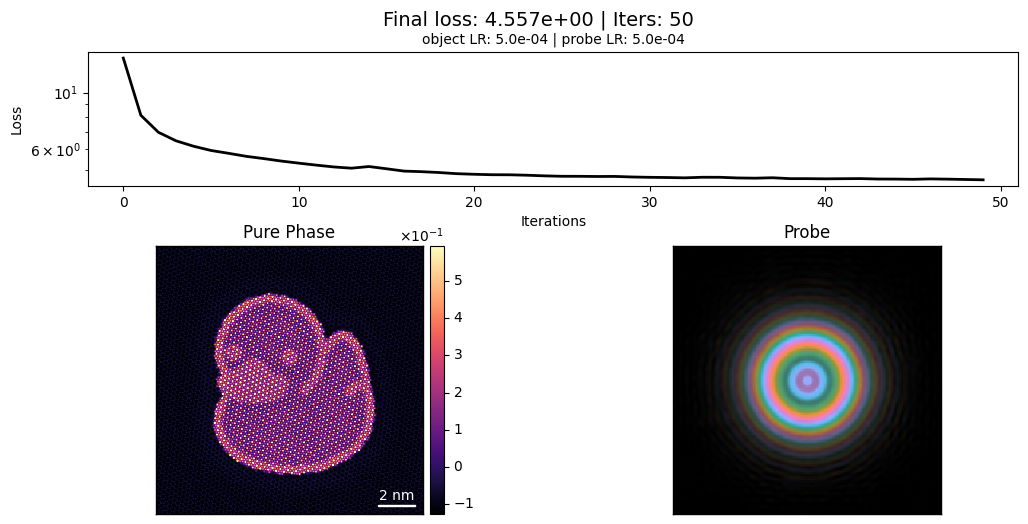

In [22]:
ptycho_dip.reconstruct(num_iters=25).visualize()

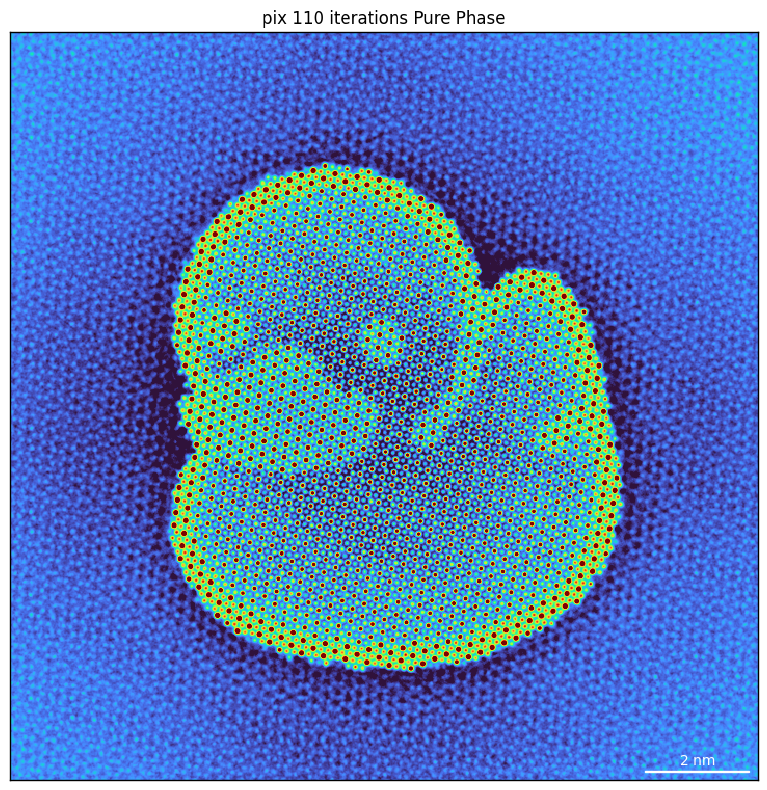

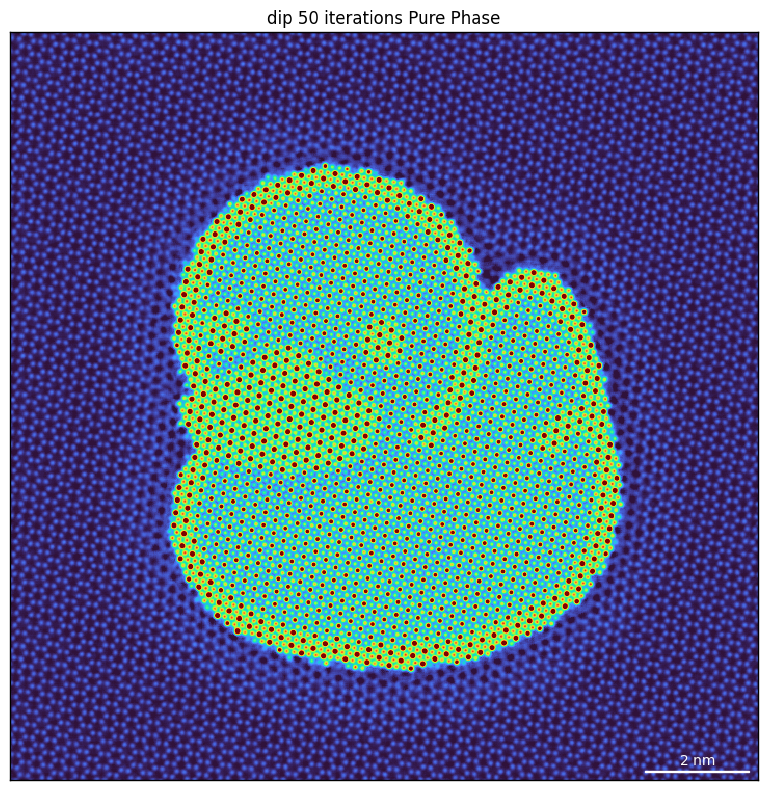

In [23]:
ptycho_pix.show_obj(axsize=(8,8), cmap='turbo', title=f'pix {ptycho_pix.num_iters} iterations')
ptycho_dip.show_obj(axsize=(8,8), cmap='turbo', title=f'dip {ptycho_dip.num_iters} iterations')

# Save/load
- can save and pick up where you left off 
- currently a bug in the DGP optimizer not saving state... will fix

In [24]:
ptycho_dip.save("../data/ptycholite_dip.zip", mode='o')

Saving ptychography object to /home/amccray/code/quantem-tutorials/notebooks/../data/ptycholite_dip.zip


In [25]:
ptycho_dip2 = PtychoLite.from_file("../data/ptycholite_dip.zip", dset = pdset)

  0%|          | 0/10 [00:00<?, ?it/s]

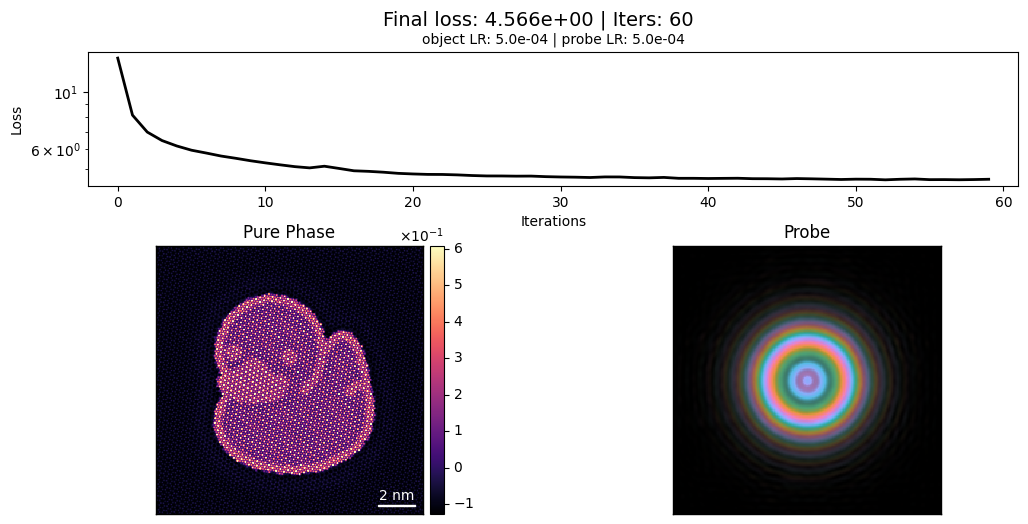

In [26]:
ptycho_dip2.reconstruct(
    num_iters=10,
    device='gpu',
).visualize()